In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [4]:
# ----------------------------
# CLASS LABELS
# ----------------------------
class_labels = ["Ajwain", "Alocasia plant", "Aloe Plant", "Amapalya", "Angelica", "Barberry", "Basil", "Beechh Tree",
"Belladonna", "Betel leaf", "Black walnuts", "Brahmi", "California", "Coriander", "Corn flower", "Curry leaves",
"Fewer few", "Garlic", "Gingko", "Golden panthos", "Hibiscus leaves", "Horse Chestnuts", "Horse tail", "Indian beech",
"Jack Fruit Leaves", "Jade tail", "Lavender", "Liquirice root", "Malunggay", "Mint", "Mother wort", "Neem", "Papaya",
"Periwinkle", "Ponytail palm palm", "Queen annes lace", "Rauwolfia", "Rosemary", "Rubber plant", "Senna",
"Slippery Elm", "Snake plant", "Swiss plant", "Tea leaves", "Terminalia leavees", "Thyme", "Turmeric leaves",
"Veronica", "Winter Green", "yellow dock"]

NUM_CLASSES = len(class_labels)

In [5]:
# ----------------------------
# DATA GENERATORS
# ----------------------------
train_dir = "dataset/train"
val_dir = "dataset/val"

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1/255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 510 images belonging to 50 classes.
Found 510 images belonging to 50 classes.


In [6]:
# ----------------------------
# MOBILENETV2 MODEL
# ----------------------------
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
preds = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,598,770 (9.91 MB)

 Trainable params: 340,786 (1.30 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# ----------------------------
# TRAIN MODEL
# ----------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30
)

model.save("plant_classifier.h5")
print("Model training complete!")

C:\Users\cheku\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.0155 - loss: 4.7483 - val_accuracy: 0.1020 - val_loss: 3.6991
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.0503 - loss: 3.8761 - val_accuracy: 0.1667 - val_loss: 3.5836
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.0777 - loss: 3.7091 - val_accuracy: 0.2529 - val_loss: 3.4280
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1011 - loss: 3.6068 - val_accuracy: 0.3255 - val_loss: 3.2031
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1107 - loss: 3.4180 - val_accuracy: 0.3941 - val_loss: 2.9609
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1370 - loss: 3.3161 - val_accuracy: 0.4647 - val_loss: 2.7019
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1860 - loss: 3.1732 - val_accuracy: 0.5118 - val_loss: 2.4560
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1859 - loss: 3.0645 - val_accuracy: 0.5725 - val_loss:

Model training complete!


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1/255)

val_gen = val_datagen.flow_from_directory(
    "dataset/val",            # 🔴 must be correct path
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False             # ❗ REQUIRED for confusion matrix
)

print("Validation generator created")


Found 510 images belonging to 50 classes.
Validation generator created


In [12]:
def plot_confusion_matrix(model, val_generator):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report

    val_generator.reset()
    y_true = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    y_pred = model.predict(val_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(22, 18))
    sns.heatmap(
        cm,
        annot=False,
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels
    )

    plt.xticks(rotation=90)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()

    # ✅ SAVE BEFORE SHOW
    plt.savefig("confusion_matrix.png", dpi=300)

    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))


Model loaded successfully


C:\Users\cheku\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 552ms/step


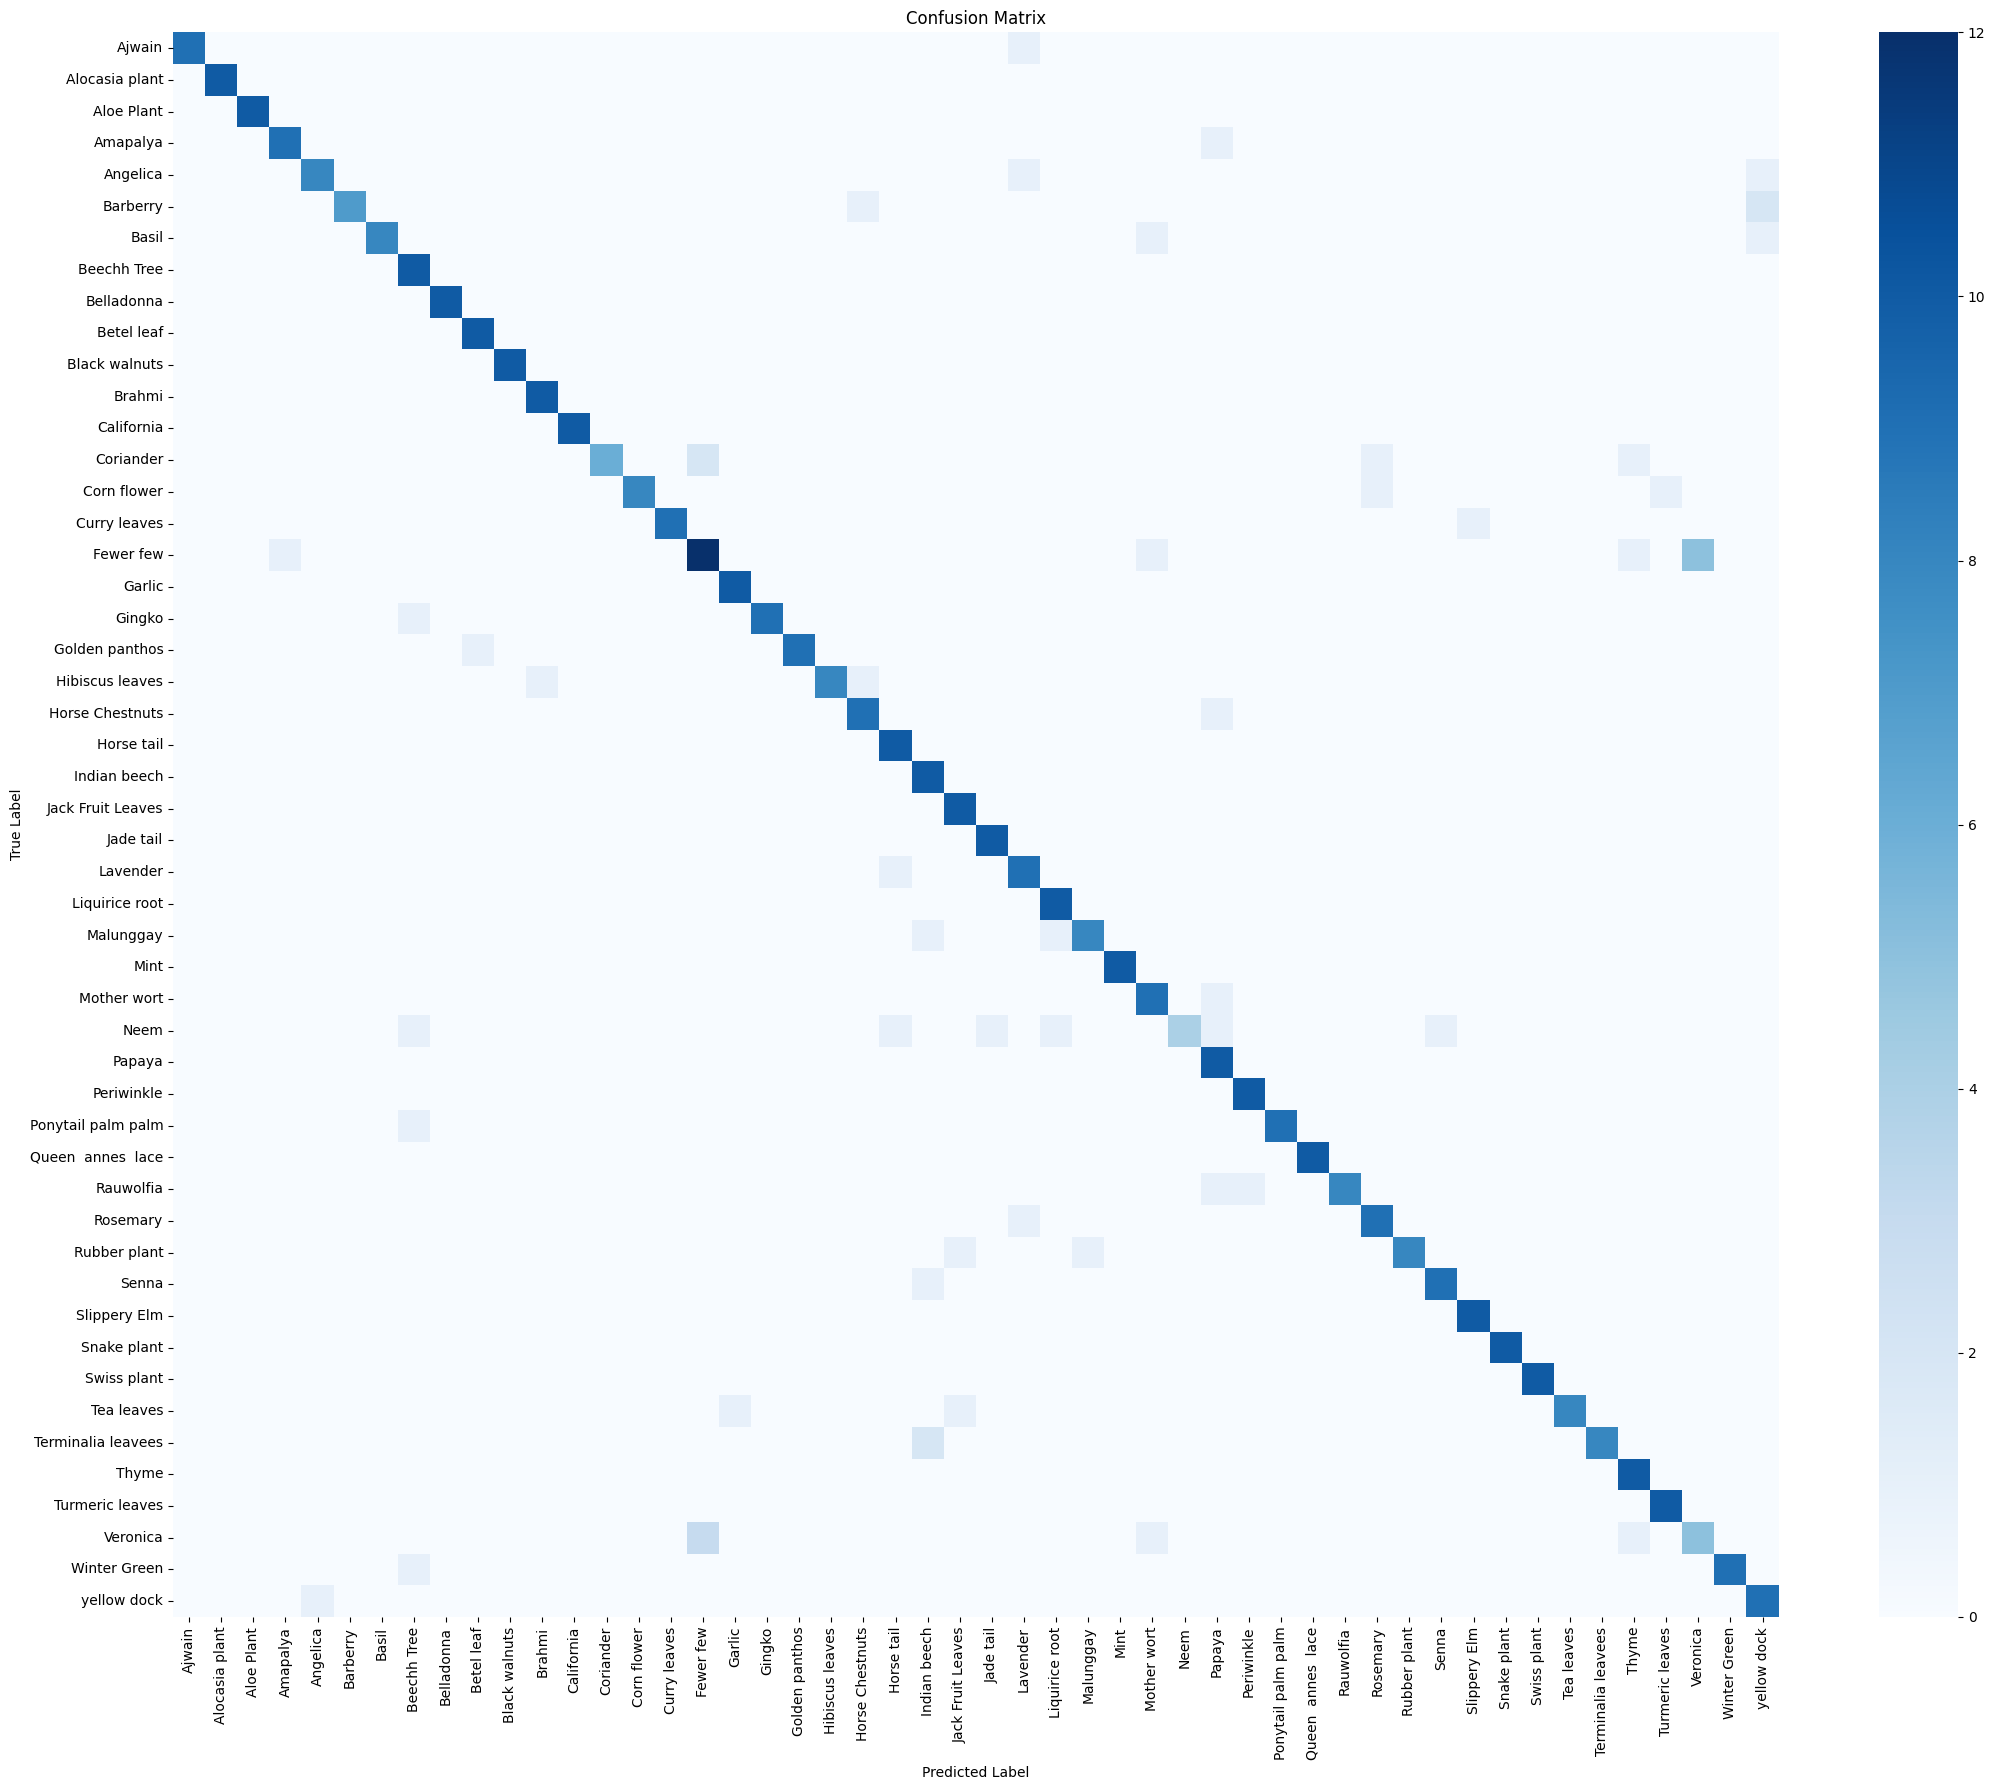


Classification Report:

                    precision    recall  f1-score   support

            Ajwain       1.00      0.90      0.95        10
    Alocasia plant       1.00      1.00      1.00        10
        Aloe Plant       1.00      1.00      1.00        10
          Amapalya       0.90      0.90      0.90        10
          Angelica       0.89      0.80      0.84        10
          Barberry       1.00      0.70      0.82        10
             Basil       1.00      0.80      0.89        10
       Beechh Tree       0.71      1.00      0.83        10
        Belladonna       1.00      1.00      1.00        10
        Betel leaf       0.91      1.00      0.95        10
     Black walnuts       1.00      1.00      1.00        10
            Brahmi       0.91      1.00      0.95        10
        California       1.00      1.00      1.00        10
         Coriander       1.00      0.60      0.75        10
       Corn flower       1.00      0.80      0.89        10
      Curry le

In [13]:
from tensorflow.keras.models import load_model

model = load_model("plant_classifier.h5")
print("Model loaded successfully")

plot_confusion_matrix(model, val_gen)